In [1]:
import os
import csv
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


dataset0
(5400, 10800)
-3835.0


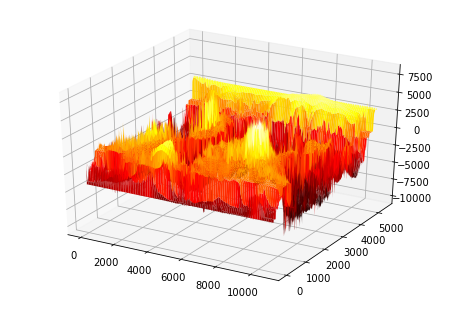

In [2]:
def printname(name):
    print(name)
f = h5py.File(os.path.join('datasets', 'topography', 'ETOPO2v2c.hdf'), "r")
f.visit(printname)
topography = f['dataset0']

print(topography.shape)
print(topography[100,130])

x = np.arange(topography.shape[1])
y = np.arange(topography.shape[0])
x, y = np.meshgrid(x, y)


fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, topography, rstride=100, cstride=100, cmap='hot')
plt.show()

In [3]:
def geo2idx(lat, long):
    '''
    Converts geographic latitude and longitude
        to indices in the topography marix.
    '''
    #assert valid lattitude and longitude:
    assert(-90 <= lat and lat <= 90)
    assert(-180 <= long and long <= 180)
    # Flip sign of latitude for index:
    lat *= -1
    # Convert offset from min-max to 0-max:
    long += 180
    long /= 2
    lat += 90
    lat /= 2
    # Convert from degrees to minutes:
    long *= 60
    lat *= 60
    return round(lat), round(long)

def idx2geo(row, col):
    '''
    Converts indices in the topography matrix to
        geographic lattitude and longitude.
    '''
    assert(0 <= row and row <= 5400)
    assert(0 <= col and col <= 10800)
    # Convert to degrees:
    row /= 60
    col /= 60
    # Convert back to min-max form
    row *= 2
    row -= 90
    col *= 2
    col -= 180
    # Flip sign of latitude for index:
    row *= -1
    return row, col

print(geo2idx(90, -180))
print(geo2idx(-90, 180))
print(geo2idx(0, 0))

print('is this ~= 280 meters?', topography[geo2idx(34.186, -84.566)])# should be approx. 280 meters
print('mount everest elevation:',topography[geo2idx(27.987788, 86.924720)]) # mount everest

row, col = np.unravel_index(np.argmax(topography), topography.shape)
print('largest point:', topography[row,col], 'meters from sea-level at', idx2geo(row, col))

row, col = np.unravel_index(np.argmin(topography), topography.shape)
print('lowest point:',  topography[row,col], 'meters from sea-level at ',idx2geo(row, col))

x,y = geo2idx(12, -76)
print("is this (12, -76)?", idx2geo(x, y))

(0, 0)
(5400, 10800)
(2700, 5400)
is this ~= 280 meters? 274.0
mount everest elevation: 7456.0
largest point: 8440.0 meters from sea-level at (28.0, 86.899999999999977)
lowest point: -10791.0 meters from sea-level at  (-23.266666666666666, -174.76666666666668)
is this (12, -76)? (12.0, -76.0)


In [4]:
import datetime as dt

def toDateTime(event):# convert the event time to a datetime object
    date = event['Date']
    time = event['Time']
    while(len(time) < 4):# make sure constant length
        time = '0' + time
    return dt.datetime(int(date[:4]), int(date[4:6]), int(date[6:]), int(time[:2]), int(time[2:]), 0)

def toHours(event, startTime):# Find the number of hours the event has been running
    secs = (toDateTime(event) - startTime).total_seconds()
    hours = secs * 1/3600 # 3600 seconds in an hour
    return hours

def toLat(event):# get the latitude as an int
    lat = event['Latitude']
    if 'N' in lat:
        lat = float(lat.replace('N',''))# remove N
    else:
        lat = -1 * float(lat.replace('S', ''))# S is neg
    return lat
    
def toLong(event):# get the longitude as an int
    long = event['Longitude']
    if 'W' in long:
        long = -1 * float(long.replace('W', ''))# W is neg
    else:
        long = float(long.replace('E', ''))
    return long

def toWind(event):# get the max wind speed as an int
    return int(event['Maximum Wind'])

startTime = None
hurricanes = []
storm = ''
with open(os.path.join('datasets', 'paths', 'atlantic.csv')) as csvfile:
    dataset = csv.DictReader(csvfile)
    for event in dataset:
        if event['Status'].replace(' ', '') == 'HU':# huricanes
            if storm == event['ID']:# not a new event
                hurricanes[-1].append([toLat(event), toLong(event), toWind(event), toHours(event, startTime)])
            else:# a new event
                storm = event['ID']# store the storm id
                startTime = toDateTime(event)# store the new date and time
                # Add a new storm list:
                hurricanes.append([ [toLat(event), toLong(event), toWind(event), toHours(event, startTime)] ])
print(len(hurricanes))

891


[[28.0, -94.8, 80, 0.0], [28.0, -95.4, 80, 6.0], [28.0, -96.0, 80, 12.0], [28.1, -96.5, 80, 18.0], [28.2, -96.8, 80, 21.0], [28.2, -97.0, 70, 24.0]]


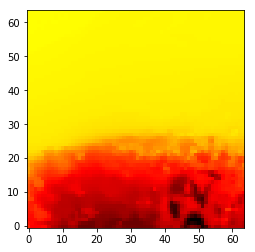

In [ ]:
print(hurricanes[0])
def getgrid(lat, long):# grab a 64x64 grid of the topography data @ coordinates (lat, long)
                       # 64x64 equates to a 128x128 arc-minute piece of topography, or about 2 degrees of land.
    xCenter, yCenter = geo2idx(lat, long)
    rows = (np.arange(64) + (xCenter - 32)) % topography.shape[0]
    cols = (np.arange(64) + (yCenter - 32)) % topography.shape[1]
    
    grid = []
    for row in rows[::-1]:# flip rows
        grid.append(topography[row][cols])
    return np.asarray(grid)

# grab the topography grid for the first hurricaine:
grid = getgrid(hurricanes[0][0][0], hurricanes[0][0][1])

# plot in 3D:
x = np.arange(grid.shape[1])
y = np.arange(grid.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, grid, rstride=1, cstride=1, cmap='hot')
plt.show()


#plot in 2D:
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                            ['black','red','yellow'], 256)
img = plt.imshow(grid,interpolation='nearest',
                cmap = cmap, origin='lower')
plt.show()